In [1]:
from elasticsearch import Elasticsearch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.axes_style("darkgrid")
sns.color_palette("colorblind", 10)
%matplotlib inline

/infres/ir430/bd/stif/anaconda2/envs/stif/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# es = Elasticsearch([{'host': 'lame14.enst.fr', 'port': 50012}])
# index_name = 'tweets-2016.02.08'
es = Elasticsearch([{'host': 'lame14.enst.fr', 'port': 50014}])
index_name = 'tweets-2016.02.16'

In [3]:
#es.get(index='tweets-2016.01.15', doc_type='tweet2', id='AVJHJ-BBioBeiNZMBu74')

In [4]:
res = es.search(index=index_name, body={
  "query": {
    "matchAll": {}
  },
  "aggs": {
    "TZ": {
      "terms": {
        "field": "user.time_zone",
        "size": 20
      }
    }
  }
})
res = res[u'aggregations'][u'TZ'][u'buckets']
df = pd.DataFrame(res)
df = df[[u'key', u'doc_count']]
df.columns = ['time_zone', 'counter']
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
time_zone,paris,canada,time,us,athens,pacific,amsterdam,ljubljana,greenland,belgrade,eastern,london,brussels,hawaii,atlantic,casablanca,central,quito,west,bern
counter,5080,2425,2425,2248,1819,1782,1483,481,426,377,341,286,241,183,181,166,158,62,56,48


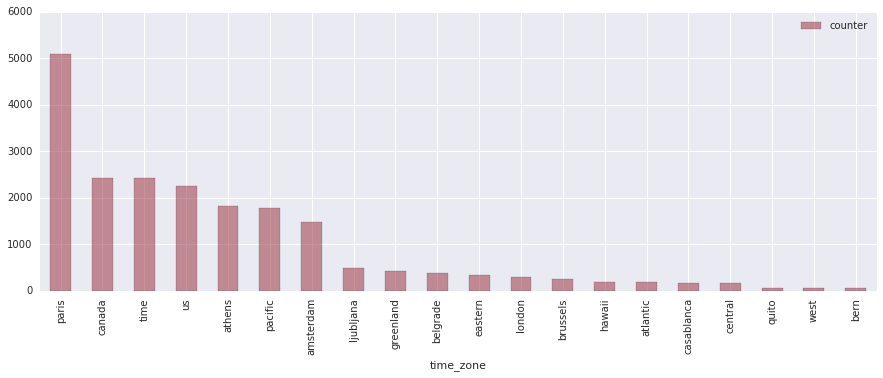

In [5]:
df.plot(kind='bar', x='time_zone', y='counter', figsize=(15, 5), color="#952836", alpha=0.5)

12295 9650


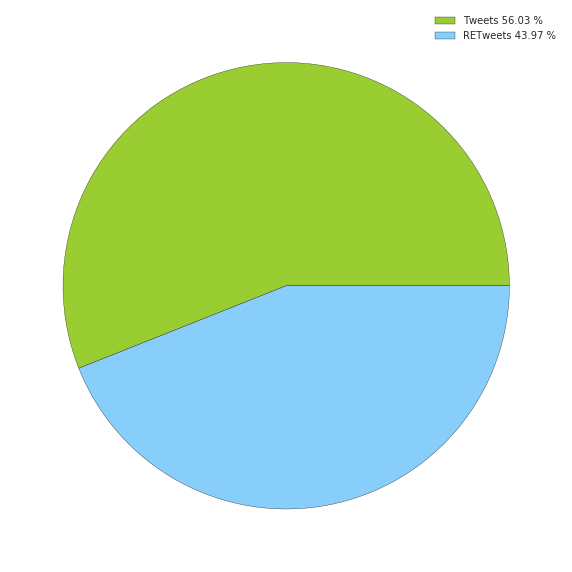

In [6]:
query_retweet_only = {
        "prefix": {
            "text": {"value": "rt"}
        }
    }

query_tweet_only = {
        "bool": {
            "must_not": {
                "prefix": {
                    "text": {"value": "rt"}
                }
            }
        }
    }

res = es.count(index=index_name, body={"query": query_tweet_only})
#print res
nb_tweets = res[u'count']
res = es.count(index=index_name, body={"query": query_retweet_only})
#print res
nb_retweets = res[u'count']
print nb_tweets, nb_retweets
df = pd.DataFrame(columns=['tweets', 'retweets'])
s = pd.Series([nb_tweets, nb_retweets], index=df.columns)
s_pct = [float(nb_tweets)/float(nb_tweets+nb_retweets)*100., float(nb_retweets)/float(nb_tweets+nb_retweets)*100.]
df = df.append(s, ignore_index=True)
df
fig = plt.figure(figsize=(10,10), dpi=200)
ax = plt.subplot(111)
#colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
colors = ['yellowgreen', 'lightskyblue']
patches, texts = plt.pie(s, colors=colors, startangle=0)
labels = [r'Tweets {:.2f} %'.format(s_pct[0], '%.2lf'), r'RETweets {:.2f} %'.format(s_pct[1], '.2f')]
plt.legend(patches, labels, loc="best")
#df.values.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=270, fontsize=17)

In [7]:
# Wordcloud
# récupérer tous les champs text
from wordcloud import WordCloud, STOPWORDS


def read_tweet_page(size, from_, query):
    res = es.search(index=index_name, body={"query": query}, size=size, from_=from_)
    res = res['hits']['hits']
    res = map(lambda t: t['_source']['text'] if 'text' in t['_source'].keys() else '', res)
    words = ' '.join(res)
    words = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' and word != '\n\r' and word != '\n'
                            ])
    return words

def get_words_from_query(query):
    pg_size = 1000

    res = read_tweet_page(pg_size, 0, query)

    cloud_data = res
    i = 1
    while len(res) == pg_size:
        res = read_tweet_page(pg_size*i, 0)
        cloud_data += ' '+ res
        print i
        i += 1
    return res

from stop_words import get_stop_words
from scipy.misc import imread

twitter_mask = imread('./twitter_mask.png', flatten=True)

FRENCH_STOPWORDS = get_stop_words('fr')

def gen_cloud_from_words(words):
    wordcloud = WordCloud(
                          font_path='MetropolitainContour.ttf',
                          stopwords=FRENCH_STOPWORDS,
                          background_color='black',
                          width=1800,
                          height=1400,
                          mask=twitter_mask
                         )

    wordcloud.generate(words)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud)
    plt.axis('off')

# ajout stop words
#more_stopwords = {'oh', 'will', 'hey', 'yet', ...}
#STOPWORDS = STOPWORDS.union(more_stopwords)


/infres/ir430/bd/stif/anaconda2/envs/stif/lib/python2.7/site-packages/wordcloud/wordcloud.py:256: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0 and"
/infres/ir430/bd/stif/anaconda2/envs/stif/lib/python2.7/site-packages/PIL/ImageDraw.py:99: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


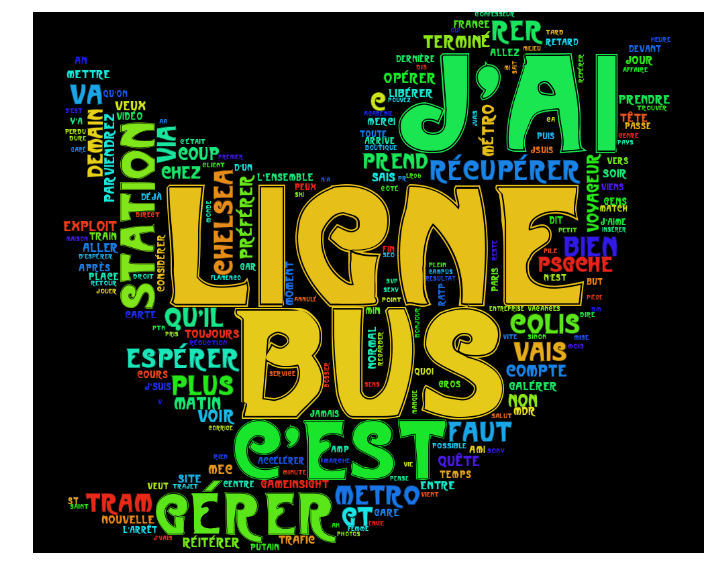

In [8]:
words = get_words_from_query(query_tweet_only)
gen_cloud_from_words(words)

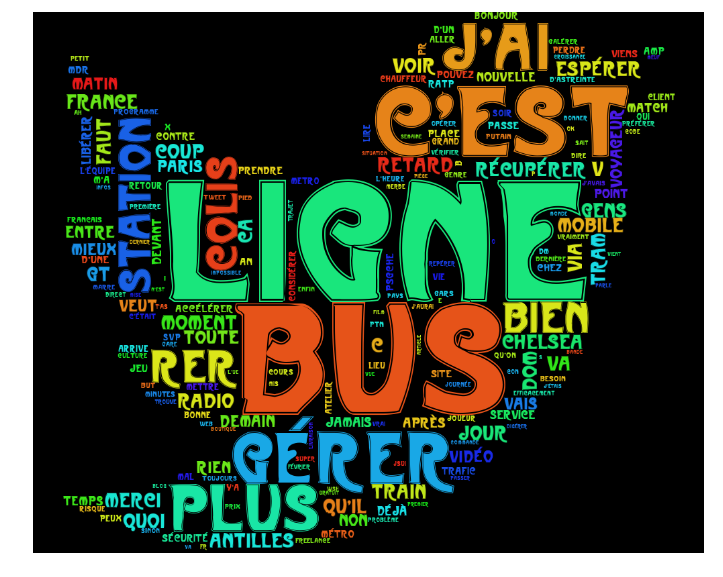

In [9]:
query_tzparis_tweet_only = {
        "bool": {
            "must_not": {
                "prefix": {
                    "text": {"value": "rt"}
                }
            },
            "should": {"match": { "user.time_zone": "paris" }}
        }
    }

words = get_words_from_query(query_tzparis_tweet_only)
gen_cloud_from_words(words)

In [18]:
Out.clear()